In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load CSV
model_df = pd.read_csv('model_df.csv')  
model_df['datetime'] = pd.to_datetime(model_df['datetime'])
model_df_24 = model_df[model_df["datetime"].dt.year == 2024].copy()

In [3]:
# Aggregate station-level mean demand
station_demand = (
    model_df_24
      .groupby("station", as_index=False)
      .agg(
          lat=("lat", "mean"),
          lon=("lon", "mean"),
          mean_demand=("total_demand", "mean")
      )
)
station_demand["mean_demand"] = station_demand["mean_demand"].round(2)

print("Number of stations:", len(station_demand))

Number of stations: 400


In [4]:
# K-Means with 3 clusters on mean_demand (low / medium / high)
X = station_demand[["mean_demand"]].values

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_ids = kmeans.fit_predict(X)

station_demand["cluster_id"] = cluster_ids

# Sort centroids to map them to low / medium / high
centers = kmeans.cluster_centers_.flatten()
order = np.argsort(centers)  # from smallest mean_demand to largest

label_map = {
    order[0]: "low",
    order[1]: "medium",
    order[2]: "high"
}

station_demand["cluster_label"] = station_demand["cluster_id"].map(label_map)

print("Cluster centers (mean demand):", centers)
print(station_demand["cluster_label"].value_counts())

Cluster centers (mean demand): [ 7.4383871 19.2321875 12.2005   ]
cluster_label
low       247
medium    120
high       33
Name: count, dtype: int64


Silhouette Score (k=3): 0.5823


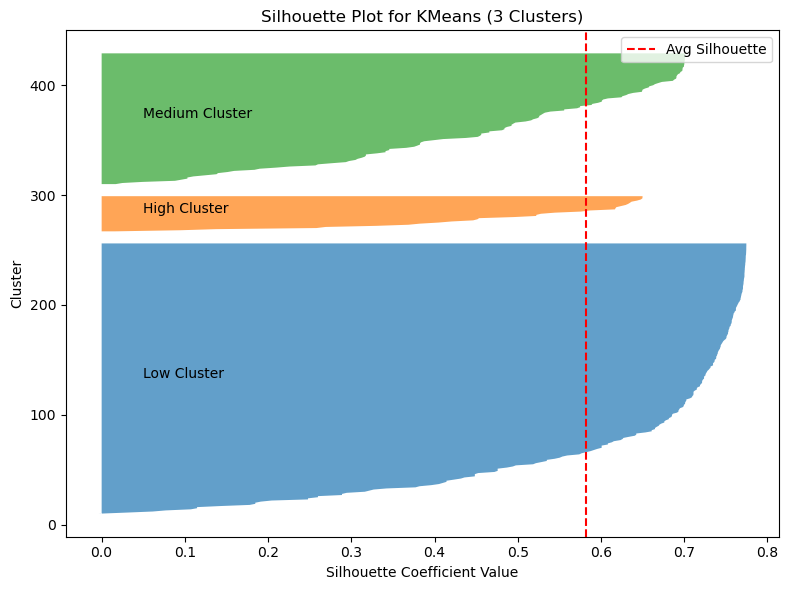

In [5]:
# Compute silhouette score
sil_score = silhouette_score(X, cluster_ids)
print(f"Silhouette Score (k=3): {sil_score:.4f}")

# Silhouette plot
sample_silhouette_values = silhouette_samples(X, cluster_ids)

fig, ax = plt.subplots(figsize=(8, 6))
y_lower = 10

for i in range(3):  # 3 clusters
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_ids == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.tab10(i)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        alpha=0.7
    )

    cluster_name = label_map.get(i, f"Cluster {i}").capitalize()
    ax.text(0.05, y_lower + 0.5 * size_cluster_i, f"{cluster_name} Cluster")

    y_lower = y_upper + 10  # Space between clusters

ax.set_title("Silhouette Plot for KMeans (3 Clusters)")
ax.set_xlabel("Silhouette Coefficient Value")
ax.set_ylabel("Cluster")

# Vertical line for average silhouette score
ax.axvline(x=sil_score, color="red", linestyle="--", label="Avg Silhouette")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()

**Interpretation:** K-Means with 3 clusters achieves moderate-to-strong separation. **The low and medium clusters** contain the majority of stations and show a wide spread of silhouette values, implying some borderline stations near cluster boundaries, while **the high cluster** is smaller but remains reasonably well separated overall.

In [6]:
# Save clusters for Streamlit
station_demand.to_csv("station_clusters.csv", index=False)